# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 2:</center>
### <center> Propiedades en Venta </center>
### <center>  Grupo 18</center>


#### **Integrantes:**

* Analía Acevedo
* Santiago Daniel Marczewski Neudeck
* Lucia Belén Napoli
* Brayan Ricaldi

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.preprocessing as skp

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from preprocessing import preprocesamiento

from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load

pd.options.display.max_columns = None

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.datasets import make_classification
from collections import defaultdict
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

import plotly.graph_objects as go
%matplotlib inline


from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow as tfa
from tensorflow import keras
import keras_tuner as kt
import visualkeras
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

np.random.seed(1)
tf.random.set_seed(1)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/home/lucia/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
2022-12-08 00:17:02.623870: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-08 00:17:03.138675: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-08 00:17:03.138711: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on 

Descargo los datos para el modelo 1

In [2]:
_x_train_model1 = pd.read_csv('./DataSet/x_train')
_x_train_model1.drop(columns=['Unnamed: 0'],inplace=True)
_y_train_model1 = pd.read_csv('./DataSet/y_train')
_y_train_model1.drop(columns=['Unnamed: 0'],inplace=True)
_x_test_model1 = pd.read_csv('./DataSet/x_test')
_x_test_model1.drop(columns=['Unnamed: 0'],inplace=True)
_y_test_model1 = pd.read_csv('./DataSet/y_test')
_y_test_model1.drop(columns=['Unnamed: 0'],inplace=True)
_y_train_model1.rename(columns={'0':'pxm2'}, inplace=True)
_y_test_model1.rename(columns={'0':'pxm2'}, inplace=True)

# Redes neuronales

Construir dos modelos de redes neuronales, uno para regresión y otro para clasificación,
considerando los datasets creados en el TP1. Mejorar estos modelos de redes
neuronales a través de la búsqueda de arquitectura e hiperparámetros adecuados. Se
pide:

● Regresión: predecir el precio de la propiedad y utilizar como métrica de
evaluación el error cuadrático medio.

● Clasificación: predecir el atributo tipo_precio creado en el TP 1 y utilizar como
métricas precisión, recall y F1-Score.


# Modelo de Redes Neuronales para clasificación

Los hiperparametros a buscar son los siguientes:

- **Función de activación:** Vamos a usar relu y softmax
- **Cantidad de capas:** Es la cantidad de capas que tendrá la red neuronal. Tendremos una capa input, ? ocultas y una capa de salida.
- **Cantidad de neuronas por capa:** Tendremos tres neuronas en la capa de salida porque son tres las clases que queremos predecir: alto, medio y bajo. En la capa de entrada tendremos 8 neuronas, la cantidad de features que tiene el dataset.
- **Optimizador:** Un optimizador es una implementación concreta del algoritmo de descenso por gradiente dentro de backpropagation.
    - SGD (Stochastic Gradient Descent): Backpropagation simple, sin ningún tipo de optimización. 
    - Adam (Adaptive moment estimation): Hace un seguimiento de una media de decaimiento exponencial de gradientes pasados y de gradientes cuadrados pasados.
- **Loss function o función de perdida:** Es la función utilizada por el optimizador para minimizar. Usaremos categorical_crossentropy.
- **Learning rate o tasa de aprendizaje:** Indica qué tan rápido se va descediendo en la función de costo, qué tan rápido va acercandose al minimo local o global.
- **Metricas:** Se van calculando en cada iteracion o batch. Utilizaremos precision, recall y F1-Score
- **Cantidad de epochs:** Es la cantidad de iteraciones que tendrá el entrenamiento. En este caso 100.

Defino funciones:

In [3]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Ejecutamos una copia de los modelos

In [4]:
x_train = _x_train_model1.copy()
y_train = _y_train_model1.copy()
x_test = _x_test_model1.copy()
y_test = _y_test_model1.copy()

Clasifico mi target

In [5]:
labels=["bajo","medio","alto"]
new_target_train, bins = pd.qcut(y_train['pxm2'],q=[0,0.25,0.75,1], labels=labels, retbins=True)

Reflejo la clasificacion en el test

In [6]:
bins[0] = min(y_test['pxm2']) - 1
bins[3] = max(y_test['pxm2']) + 1

In [7]:
new_target_test = pd.cut(y_test['pxm2'], bins=bins, labels=labels, include_lowest=True)

In [8]:
y_train = new_target_train
y_test = new_target_test

In [9]:
x_train.head()

,latitud,longitud,ambientes,dormitorios,superficie_cubierta,comuna,Departamento,PH
0,-34.583010,-58.481533,4.0,3.0,70.0,15,1.0,0.0
1,-34.660079,-58.485894,6.0,4.0,275.0,9,0.0,0.0
2,-34.581856,-58.425088,3.0,2.0,97.0,14,1.0,0.0
3,-34.607547,-58.442194,2.0,1.0,42.0,6,1.0,0.0
4,-34.607416,-58.509680,2.0,1.0,38.0,11,1.0,0.0


In [10]:
y_train.head()

0     alto
1     bajo
2    medio
3     bajo
4     alto
Name: pxm2, dtype: category
Categories (3, object): ['bajo' < 'medio' < 'alto']

In [11]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [12]:
x_train_scaled[0:5]

array([[ 0.50172268, -1.12215239,  0.89519544,  1.11266314, -0.0867647 ,
         1.27157065,  0.40756802, -0.34041477],
       [-2.41244287, -1.23741004,  2.38416976,  2.11040252,  3.24390971,
         0.04401013, -2.45357818, -0.34041477],
       [ 0.54533212,  0.36963696,  0.15070829,  0.11492376,  0.35190949,
         1.06697723,  0.40756802, -0.34041477],
       [-0.42611094, -0.08247136, -0.59377887, -0.88281562, -0.54168608,
        -0.56977013,  0.40756802, -0.34041477],
       [-0.42116132, -1.86603329, -0.59377887, -0.88281562, -0.60667485,
         0.45319697,  0.40756802, -0.34041477]])

In [13]:
x_test_scaled[0:5]

array([[ 0.71775929,  0.84185548,  0.89519544,  1.11266314,  1.45671856,
        -1.59273724, -2.45357818, 45.55169185],
       [ 1.93801313, -0.55876081,  0.89519544,  1.11266314,  0.3356623 ,
        -1.59273724, -2.45357818, 42.27368424],
       [ 0.15948763,  1.1736359 ,  0.89519544,  1.11266314,  0.69310053,
        -1.59273724, -2.45357818,  6.21560046],
       [-1.23918317,  0.15928422, -1.33826603, -0.88281562, -0.68791081,
        -1.59273724, -2.45357818, 22.60563854],
       [ 0.15594841,  1.60679493,  0.15070829,  0.11492376,  1.31049383,
        -1.59273724, -2.45357818,  2.93759284]])

In [14]:
# One hot encoding
enc = OneHotEncoder()
y_train_encoder = enc.fit_transform(y_train[:, np.newaxis]).toarray()
y_test_encoder = enc.transform(y_test[:, np.newaxis]).toarray()

In [15]:
y_train_encoder[0:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [16]:
y_test_encoder[0:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

+ Cantidad de capas ocultas tiene que estar entre 3 y 8

In [17]:
cant_clases = len(np.unique(y_train))

d_in = len(x_train.columns.tolist())

## Modelo 1

In [18]:
modelo_1 = keras.Sequential([
    
    keras.layers.Dense(8,input_shape=(d_in,), activation='relu'),
    
    keras.layers.Dense(5, activation='relu'),
    
    keras.layers.Dense(cant_clases, activation='softmax')])

modelo_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________


2022-12-08 00:17:36.206049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-08 00:17:36.206551: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-08 00:17:36.206589: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lucia-UbuntuNotebook): /proc/driver/nvidia/version does not exist
2022-12-08 00:17:36.207348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
modelo_1.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='categorical_crossentropy', 
  metrics=[precision_m, recall_m, f1_m], 
)

In [20]:
cant_epochs=50

historia_modelo_1 = modelo_1.fit(x_train_scaled,y_train_encoder,epochs=cant_epochs,batch_size=10)

Epoch 1/50
5814/5814 [==============================] - 12s 2ms/step - loss: 0.8666 - precision_m: 0.6191 - recall_m: 0.4779 - f1_m: 0.5336
Epoch 2/50
5814/5814 [==============================] - 11s 2ms/step - loss: 0.8170 - precision_m: 0.6377 - recall_m: 0.5534 - f1_m: 0.5903
Epoch 3/50
5814/5814 [==============================] - 11s 2ms/step - loss: 0.8063 - precision_m: 0.6388 - recall_m: 0.5628 - f1_m: 0.5963
Epoch 4/50
5814/5814 [==============================] - 11s 2ms/step - loss: 0.8009 - precision_m: 0.6401 - recall_m: 0.5691 - f1_m: 0.6005
Epoch 5/50
5814/5814 [==============================] - 11s 2ms/step - loss: 0.7974 - precision_m: 0.6404 - recall_m: 0.5725 - f1_m: 0.6026
Epoch 6/50
5814/5814 [==============================] - 11s 2ms/step - loss: 0.7951 - precision_m: 0.6405 - recall_m: 0.5750 - f1_m: 0.6041
Epoch 7/50
5814/5814 [==============================] - 11s 2ms/step - loss: 0.7921 - precision_m: 0.6404 - recall_m: 0.5760 - f1_m: 0.6047
Epoch 8/50
5814/5814

In [21]:
y_predic = modelo_1.predict(x_test_scaled)

455/455 [==============================] - 1s 2ms/step


In [22]:
y_predic[0:5]

array([[8.1330556e-03, 2.5405927e-02, 9.6646100e-01],
       [4.5680249e-01, 5.2781434e-05, 5.4314476e-01],
       [1.3955226e-02, 7.3037189e-01, 2.5567293e-01],
       [6.2690419e-06, 9.0257126e-01, 9.7422443e-02],
       [7.1451604e-02, 5.5630898e-01, 3.7223944e-01]], dtype=float32)

In [23]:
y_predic_clases=np.argmax(y_predic,axis=1).tolist()
y_real_clases=np.argmax(y_test_encoder,axis=1).tolist()

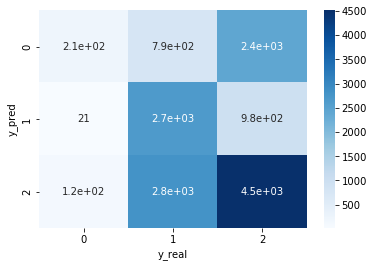

In [24]:
ds_validacion=pd.DataFrame(y_predic_clases,y_real_clases).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [25]:
epochs = range(cant_epochs)

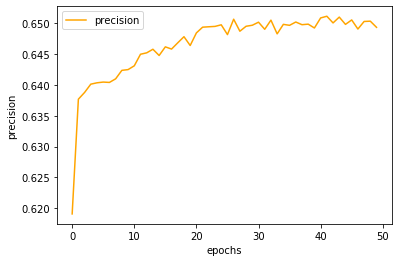

In [26]:
plt.plot(epochs, historia_modelo_1.history['precision_m'], color='orange', label='precision')
plt.xlabel("epochs")
plt.ylabel("precision")
plt.legend()

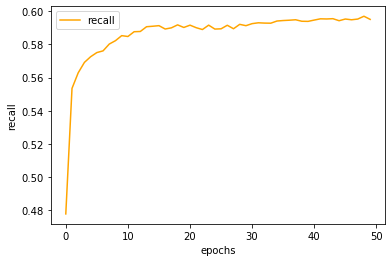

In [27]:
plt.plot(epochs, historia_modelo_1.history['recall_m'], color='orange', label='recall')
plt.xlabel("epochs")
plt.ylabel("recall")
plt.legend()

In [28]:
#Arbol Reporte y Matriz de Confusion
y_pred=np.argmax(y_predic,axis=1)
y_test_enc=np.argmax(y_test_encoder,axis=1)

print(classification_report(y_test_enc,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.06      0.11      3438
           1       0.43      0.73      0.54      3660
           2       0.57      0.61      0.59      7436

    accuracy                           0.51     14534
   macro avg       0.53      0.46      0.41     14534
weighted avg       0.54      0.51      0.46     14534



In [29]:
print('Accuracy: {}'.format(accuracy_score(y_test_enc, y_pred))) 
print('Precision: {}'.format(precision_score(y_test_enc, y_pred, average= 'micro'))) 
print('Recall: {}'.format(recall_score(y_test_enc, y_pred, average= 'micro'))) 
print('F1-Score: {}'.format(f1_score(y_test_enc, y_pred, average= 'micro'))) 

Accuracy: 0.507774872712261
Precision: 0.507774872712261
Recall: 0.507774872712261
F1-Score: 0.507774872712261


## Modelo 2: incremento epochs y batches

In [47]:
modelo_2 = keras.Sequential([
    
    keras.layers.Dense(8,input_shape=(d_in,), activation='relu'),
    
    keras.layers.Dense(5, activation='relu'),
    
    keras.layers.Dense(cant_clases, activation='softmax')])

modelo_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 5)                 45        
                                                                 
 dense_5 (Dense)             (None, 3)                 18        
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________


In [48]:
modelo_2.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.01), 
  loss='categorical_crossentropy', 
  metrics=[precision_m, recall_m, f1_m], 
)

In [50]:
cant_epochs=100

historia_modelo_1 = modelo_1.fit(x_train_scaled,y_train_encoder,epochs=cant_epochs,batch_size=10, verbose=2)

Epoch 1/100
5814/5814 - 8s - loss: 0.7804 - precision_m: 0.6453 - recall_m: 0.5912 - f1_m: 0.6156 - 8s/epoch - 1ms/step
Epoch 2/100
5814/5814 - 8s - loss: 0.7803 - precision_m: 0.6449 - recall_m: 0.5920 - f1_m: 0.6158 - 8s/epoch - 1ms/step
Epoch 3/100
5814/5814 - 8s - loss: 0.7804 - precision_m: 0.6448 - recall_m: 0.5917 - f1_m: 0.6157 - 8s/epoch - 1ms/step
Epoch 4/100
5814/5814 - 8s - loss: 0.7799 - precision_m: 0.6453 - recall_m: 0.5928 - f1_m: 0.6164 - 8s/epoch - 1ms/step
Epoch 5/100
5814/5814 - 8s - loss: 0.7795 - precision_m: 0.6459 - recall_m: 0.5921 - f1_m: 0.6163 - 8s/epoch - 1ms/step
Epoch 6/100
5814/5814 - 8s - loss: 0.7796 - precision_m: 0.6439 - recall_m: 0.5922 - f1_m: 0.6155 - 8s/epoch - 1ms/step
Epoch 7/100
5814/5814 - 8s - loss: 0.7796 - precision_m: 0.6430 - recall_m: 0.5912 - f1_m: 0.6145 - 8s/epoch - 1ms/step
Epoch 8/100
5814/5814 - 8s - loss: 0.7793 - precision_m: 0.6442 - recall_m: 0.5917 - f1_m: 0.6153 - 8s/epoch - 1ms/step
Epoch 9/100
5814/5814 - 8s - loss: 0.779

In [51]:
y_predic = modelo_1.predict(x_test_scaled)

455/455 [==============================] - 1s 2ms/step


In [52]:
y_predic[0:5]

array([[9.8563055e-07, 9.5902944e-01, 4.0969599e-02],
       [1.3447882e-06, 9.5482904e-01, 4.5169670e-02],
       [2.7061166e-02, 4.4868624e-01, 5.2425253e-01],
       [9.4010271e-03, 3.7383810e-01, 6.1676085e-01],
       [4.8866805e-02, 4.2595211e-01, 5.2518106e-01]], dtype=float32)

In [53]:
y_predic_clases=np.argmax(y_predic,axis=1).tolist()
y_real_clases=np.argmax(y_test_encoder,axis=1).tolist()

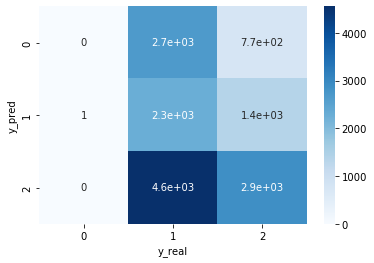

In [54]:
ds_validacion=pd.DataFrame(y_predic_clases,y_real_clases).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [55]:
epochs = range(cant_epochs)

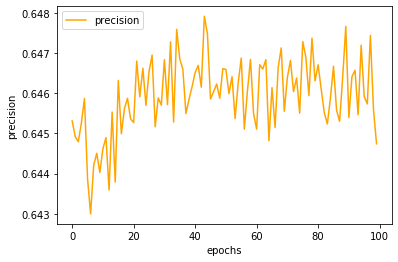

In [56]:
plt.plot(epochs, historia_modelo_1.history['precision_m'], color='orange', label='precision')
plt.xlabel("epochs")
plt.ylabel("precision")
plt.legend()

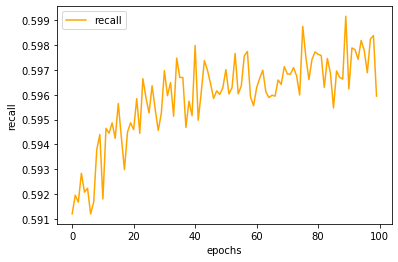

In [57]:
plt.plot(epochs, historia_modelo_1.history['recall_m'], color='orange', label='recall')
plt.xlabel("epochs")
plt.ylabel("recall")
plt.legend()

In [58]:
#Arbol Reporte y Matriz de Confusion
y_pred=np.argmax(y_predic,axis=1)
y_test_enc=np.argmax(y_test_encoder,axis=1)

print(classification_report(y_test_enc,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3438
           1       0.24      0.62      0.35      3660
           2       0.57      0.39      0.46      7436

    accuracy                           0.36     14534
   macro avg       0.27      0.34      0.27     14534
weighted avg       0.35      0.36      0.32     14534



In [59]:
print('Accuracy: {}'.format(accuracy_score(y_test_enc, y_pred))) 
print('Precision: {}'.format(precision_score(y_test_enc, y_pred, average= 'micro'))) 
print('Recall: {}'.format(recall_score(y_test_enc, y_pred, average= 'micro'))) 
print('F1-Score: {}'.format(f1_score(y_test_enc, y_pred, average= 'micro'))) 

Accuracy: 0.35571762763176
Precision: 0.35571762763176
Recall: 0.35571762763176
F1-Score: 0.35571762763176


## Modelo 3: cambio learning rate

In [67]:
modelo_3 = keras.Sequential([
    
    keras.layers.Dense(8,input_shape=(d_in,), activation='relu'),
    
    keras.layers.Dense(5, activation='relu'),
    
    keras.layers.Dense(cant_clases, activation='softmax')])

modelo_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8)                 72        
                                                                 
 dense_7 (Dense)             (None, 5)                 45        
                                                                 
 dense_8 (Dense)             (None, 3)                 18        
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________


In [68]:
modelo_3.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.001), 
  loss='categorical_crossentropy', 
  metrics=[precision_m, recall_m, f1_m], 
)

In [69]:
cant_epochs=100

historia_modelo_3 = modelo_3.fit(x_train_scaled,y_train_encoder,epochs=cant_epochs,batch_size=10, verbose=2)

Epoch 1/100
5814/5814 - 9s - loss: 0.9884 - precision_m: 0.5794 - recall_m: 0.2419 - f1_m: 0.3307 - 9s/epoch - 1ms/step
Epoch 2/100
5814/5814 - 8s - loss: 0.8960 - precision_m: 0.6300 - recall_m: 0.3715 - f1_m: 0.4584 - 8s/epoch - 1ms/step
Epoch 3/100
5814/5814 - 8s - loss: 0.8521 - precision_m: 0.6373 - recall_m: 0.4865 - f1_m: 0.5470 - 8s/epoch - 1ms/step
Epoch 4/100
5814/5814 - 8s - loss: 0.8369 - precision_m: 0.6365 - recall_m: 0.5299 - f1_m: 0.5753 - 8s/epoch - 1ms/step
Epoch 5/100
5814/5814 - 8s - loss: 0.8307 - precision_m: 0.6369 - recall_m: 0.5409 - f1_m: 0.5823 - 8s/epoch - 1ms/step
Epoch 6/100
5814/5814 - 8s - loss: 0.8274 - precision_m: 0.6378 - recall_m: 0.5467 - f1_m: 0.5862 - 8s/epoch - 1ms/step
Epoch 7/100
5814/5814 - 8s - loss: 0.8252 - precision_m: 0.6386 - recall_m: 0.5484 - f1_m: 0.5875 - 8s/epoch - 1ms/step
Epoch 8/100
5814/5814 - 8s - loss: 0.8237 - precision_m: 0.6390 - recall_m: 0.5500 - f1_m: 0.5886 - 8s/epoch - 1ms/step
Epoch 9/100
5814/5814 - 8s - loss: 0.822

In [70]:
y_predic = modelo_1.predict(x_test_scaled)

455/455 [==============================] - 1s 2ms/step


In [71]:
y_predic[0:5]

array([[9.8563055e-07, 9.5902944e-01, 4.0969599e-02],
       [1.3447882e-06, 9.5482904e-01, 4.5169670e-02],
       [2.7061166e-02, 4.4868624e-01, 5.2425253e-01],
       [9.4010271e-03, 3.7383810e-01, 6.1676085e-01],
       [4.8866805e-02, 4.2595211e-01, 5.2518106e-01]], dtype=float32)

In [72]:
y_predic_clases=np.argmax(y_predic,axis=1).tolist()
y_real_clases=np.argmax(y_test_encoder,axis=1).tolist()

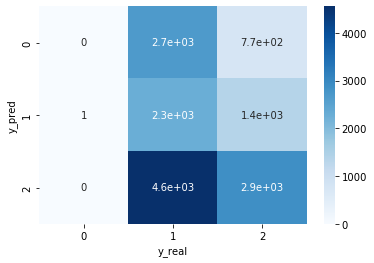

In [73]:
ds_validacion=pd.DataFrame(y_predic_clases,y_real_clases).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [74]:
epochs = range(cant_epochs)

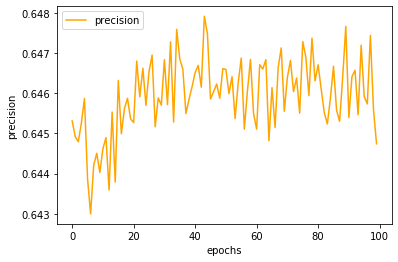

In [75]:
plt.plot(epochs, historia_modelo_1.history['precision_m'], color='orange', label='precision')
plt.xlabel("epochs")
plt.ylabel("precision")
plt.legend()

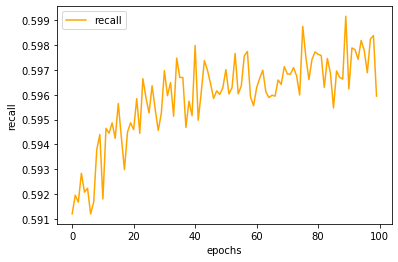

In [76]:
plt.plot(epochs, historia_modelo_1.history['recall_m'], color='orange', label='recall')
plt.xlabel("epochs")
plt.ylabel("recall")
plt.legend()

In [77]:
#Arbol Reporte y Matriz de Confusion
y_pred=np.argmax(y_predic,axis=1)
y_test_enc=np.argmax(y_test_encoder,axis=1)

print(classification_report(y_test_enc,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3438
           1       0.24      0.62      0.35      3660
           2       0.57      0.39      0.46      7436

    accuracy                           0.36     14534
   macro avg       0.27      0.34      0.27     14534
weighted avg       0.35      0.36      0.32     14534



In [78]:
print('Accuracy: {}'.format(accuracy_score(y_test_enc, y_pred))) 
print('Precision: {}'.format(precision_score(y_test_enc, y_pred, average= 'micro'))) 
print('Recall: {}'.format(recall_score(y_test_enc, y_pred, average= 'micro'))) 
print('F1-Score: {}'.format(f1_score(y_test_enc, y_pred, average= 'micro'))) 

Accuracy: 0.35571762763176
Precision: 0.35571762763176
Recall: 0.35571762763176
F1-Score: 0.35571762763176


Con la misma cantidad de epochs y batches no hay diferencia en los resultados obtenidos

## Modelo 4: incremento batches y optimizador adam

In [ ]:
modelo_4 = keras.Sequential([
    
    keras.layers.Dense(8,input_shape=(d_in,), activation='relu'),
    
    keras.layers.Dense(5, activation='relu'),
    
    keras.layers.Dense(cant_clases, activation='softmax')])

modelo_4.summary()

In [ ]:
modelo_4.compile(
  optimizer='adam', 
  loss='categorical_crossentropy', 
  metrics=[precision_m, recall_m, f1_m], 
)

In [50]:
cant_epochs=100

historia_modelo_1 = modelo_1.fit(x_train_scaled,y_train_encoder,epochs=cant_epochs,batch_size=18, verbose=2)

Epoch 1/100
5814/5814 - 8s - loss: 0.7804 - precision_m: 0.6453 - recall_m: 0.5912 - f1_m: 0.6156 - 8s/epoch - 1ms/step
Epoch 2/100
5814/5814 - 8s - loss: 0.7803 - precision_m: 0.6449 - recall_m: 0.5920 - f1_m: 0.6158 - 8s/epoch - 1ms/step
Epoch 3/100
5814/5814 - 8s - loss: 0.7804 - precision_m: 0.6448 - recall_m: 0.5917 - f1_m: 0.6157 - 8s/epoch - 1ms/step
Epoch 4/100
5814/5814 - 8s - loss: 0.7799 - precision_m: 0.6453 - recall_m: 0.5928 - f1_m: 0.6164 - 8s/epoch - 1ms/step
Epoch 5/100
5814/5814 - 8s - loss: 0.7795 - precision_m: 0.6459 - recall_m: 0.5921 - f1_m: 0.6163 - 8s/epoch - 1ms/step
Epoch 6/100
5814/5814 - 8s - loss: 0.7796 - precision_m: 0.6439 - recall_m: 0.5922 - f1_m: 0.6155 - 8s/epoch - 1ms/step
Epoch 7/100
5814/5814 - 8s - loss: 0.7796 - precision_m: 0.6430 - recall_m: 0.5912 - f1_m: 0.6145 - 8s/epoch - 1ms/step
Epoch 8/100
5814/5814 - 8s - loss: 0.7793 - precision_m: 0.6442 - recall_m: 0.5917 - f1_m: 0.6153 - 8s/epoch - 1ms/step
Epoch 9/100
5814/5814 - 8s - loss: 0.779

In [51]:
y_predic = modelo_1.predict(x_test_scaled)

455/455 [==============================] - 1s 2ms/step


In [52]:
y_predic[0:5]

array([[9.8563055e-07, 9.5902944e-01, 4.0969599e-02],
       [1.3447882e-06, 9.5482904e-01, 4.5169670e-02],
       [2.7061166e-02, 4.4868624e-01, 5.2425253e-01],
       [9.4010271e-03, 3.7383810e-01, 6.1676085e-01],
       [4.8866805e-02, 4.2595211e-01, 5.2518106e-01]], dtype=float32)

In [53]:
y_predic_clases=np.argmax(y_predic,axis=1).tolist()
y_real_clases=np.argmax(y_test_encoder,axis=1).tolist()

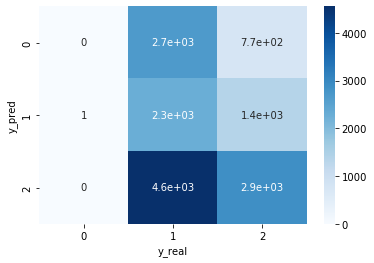

In [54]:
ds_validacion=pd.DataFrame(y_predic_clases,y_real_clases).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [55]:
epochs = range(cant_epochs)

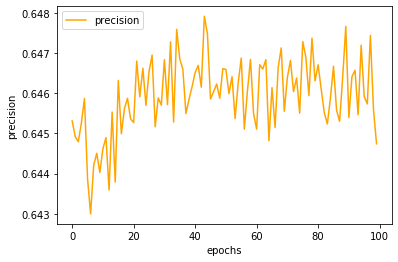

In [56]:
plt.plot(epochs, historia_modelo_1.history['precision_m'], color='orange', label='precision')
plt.xlabel("epochs")
plt.ylabel("precision")
plt.legend()

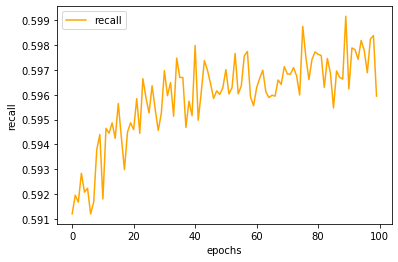

In [57]:
plt.plot(epochs, historia_modelo_1.history['recall_m'], color='orange', label='recall')
plt.xlabel("epochs")
plt.ylabel("recall")
plt.legend()

In [58]:
#Arbol Reporte y Matriz de Confusion
y_pred=np.argmax(y_predic,axis=1)
y_test_enc=np.argmax(y_test_encoder,axis=1)

print(classification_report(y_test_enc,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3438
           1       0.24      0.62      0.35      3660
           2       0.57      0.39      0.46      7436

    accuracy                           0.36     14534
   macro avg       0.27      0.34      0.27     14534
weighted avg       0.35      0.36      0.32     14534



In [59]:
print('Accuracy: {}'.format(accuracy_score(y_test_enc, y_pred))) 
print('Precision: {}'.format(precision_score(y_test_enc, y_pred, average= 'micro'))) 
print('Recall: {}'.format(recall_score(y_test_enc, y_pred, average= 'micro'))) 
print('F1-Score: {}'.format(f1_score(y_test_enc, y_pred, average= 'micro'))) 

Accuracy: 0.35571762763176
Precision: 0.35571762763176
Recall: 0.35571762763176
F1-Score: 0.35571762763176


## Modelo: Cross validation

In [101]:
def create_model(lr, neurona):
    
    modelo = keras.Sequential([
    keras.layers.Dense(8,input_shape=(d_in,), activation='relu'),
    keras.layers.Dense(neurona, activation='relu'),
    keras.layers.Dense(cant_clases, activation='softmax')])
    
        
    modelo.compile(
      optimizer=keras.optimizers.SGD(learning_rate=lr), 
      loss='categorical_crossentropy', 
      metrics=[precision_m, recall_m, f1_m],
    )
    
    return modelo

In [102]:
modelo_cv = KerasClassifier(build_fn=create_model, epochs=50, batch_size=10)

In [ ]:
lr = [0.001, 0.01]
neurona = [4, 5, 6]

param_grid = dict(lr=lr, neurona=neurona)

grid = GridSearchCV(estimator=modelo_cv, param_grid=param_grid, verbose=2)
grid_result = grid.fit(x_train_scaled, y_train_encoder)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Epoch 1/50
4651/4651 [==============================] - 10s 2ms/step - loss: 1.0387 - precision_m: 0.4123 - recall_m: 0.1258 - f1_m: 0.1847
Epoch 2/50
4651/4651 [==============================] - 9s 2ms/step - loss: 0.9679 - precision_m: 0.5272 - recall_m: 0.2337 - f1_m: 0.3150
Epoch 3/50
4651/4651 [==============================] - 9s 2ms/step - loss: 0.9237 - precision_m: 0.5756 - recall_m: 0.2500 - f1_m: 0.3386
Epoch 4/50
4651/4651 [==============================] - 9s 2ms/step - loss: 0.8982 - precision_m: 0.6154 - recall_m: 0.2961 - f1_m: 0.3889
Epoch 5/50
4651/4651 [==============================] - 9s 2ms/step - loss: 0.8835 - precision_m: 0.6131 - recall_m: 0.3885 - f1_m: 0.4686
Epoch 6/50
4651/4651 [==============================] - 9s 2ms/step - loss: 0.8740 - precision_m: 0.6072 - recall_m: 0.4225 - f1_m: 0.4928
Epoch 7/50
4651/4651 [==============================] - 9s 2ms/step - loss: 0.8666 - precision_m: 0.6074 

/home/lucia/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucia/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/lucia/.local/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/home/lucia/.local/lib/python3.8/site-packages/keras/wrappers/scikit_learn.py", line 335, in score
    raise ValueError(
ValueError: The model is not configured to compute accuracy. You should pass `metrics=["accuracy"]` to the `model.compile()` method.

  warnings.warn(


4651/4651 [==============================] - 8s 2ms/step - loss: 1.0512 - precision_m: 0.3774 - recall_m: 0.1354 - f1_m: 0.1872
Epoch 2/50
4651/4651 [==============================] - 8s 2ms/step - loss: 1.0114 - precision_m: 0.5763 - recall_m: 0.3355 - f1_m: 0.4168
Epoch 3/50
4651/4651 [==============================] - 8s 2ms/step - loss: 0.9902 - precision_m: 0.5818 - recall_m: 0.3533 - f1_m: 0.4325
Epoch 4/50
4651/4651 [==============================] - 8s 2ms/step - loss: 0.9630 - precision_m: 0.5858 - recall_m: 0.3621 - f1_m: 0.4410
Epoch 5/50
4651/4651 [==============================] - 8s 2ms/step - loss: 0.9318 - precision_m: 0.5875 - recall_m: 0.3764 - f1_m: 0.4524
Epoch 6/50
4651/4651 [==============================] - 8s 2ms/step - loss: 0.9046 - precision_m: 0.5969 - recall_m: 0.3789 - f1_m: 0.4568
Epoch 7/50
4651/4651 [==============================] - 8s 2ms/step - loss: 0.8837 - precision_m: 0.6159 - recall_m: 0.4421 - f1_m: 0.5091
Epoch 8/50
4651/4651 [================

-----------

----
